In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
from pyproj import CRS, Transformer

# --- CONFIGURATION ---
INPUT_FILE = "Path wise sorted DGPS Kotturpuram.xlsx"
# Chennai is UTM Zone 44N (EPSG:32644)
UTM_CRS = "EPSG:32644" 
WGS84_CRS = "EPSG:4326"

# 1. LOAD AND PROJECT DATA
df = pd.read_excel(INPUT_FILE)

# Transformer for Easting/Northing (Zone 44N) to Lat/Lon
transformer = Transformer.from_crs(UTM_CRS, WGS84_CRS, always_xy=True)
df["Longitude"], df["Latitude"] = transformer.transform(df["Easting"].values, df["Northing"].values)

# Create GeoDataFrame for Nodes
gdf_nodes = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs=WGS84_CRS
)

# 2. CREATE TOPOLOGICAL EDGES (Segments)
# We iterate through the ID-sorted rows to create line segments
edge_records = []

def calculate_bearing(p1, p2):
    """Calculates the bearing between two points in degrees."""
    lat1, lon1 = np.radians(p1.y), np.radians(p1.x)
    lat2, lon2 = np.radians(p2.y), np.radians(p2.x)
    dLon = lon2 - lon1
    y = np.sin(dLon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360

for i in range(len(gdf_nodes) - 1):
    node_a = gdf_nodes.iloc[i]
    node_b = gdf_nodes.iloc[i+1]
    
    # Create the segment geometry
    line = LineString([node_a.geometry, node_b.geometry])
    
    edge_records.append({
        "edge_id": i,
        "from_id": node_a["ID"],
        "to_id": node_b["ID"],
        "des": node_a["DES"],  # Preserving metadata (e.g., E1GM, BASESESTN)
        "bearing": calculate_bearing(node_a.geometry, node_b.geometry),
        "geometry": line
    })

gdf_edges = gpd.GeoDataFrame(edge_records, crs=WGS84_CRS)

# 3. METRIC REFINEMENT
# Project to UTM for accurate metric length calculation
gdf_edges_metric = gdf_edges.to_crs(UTM_CRS)
gdf_edges["length_m"] = gdf_edges_metric.geometry.length

# 4. EXPORT FOR MAP MATCHING
gdf_nodes.to_file("base_map_nodes.shp")
gdf_edges.to_file("base_map_edges.shp")

print(f"Base map built with {len(gdf_edges)} edges.")
print("Calculated metric lengths and bearings for orientation-aware matching.")

Base map built with 76 edges.
Calculated metric lengths and bearings for orientation-aware matching.


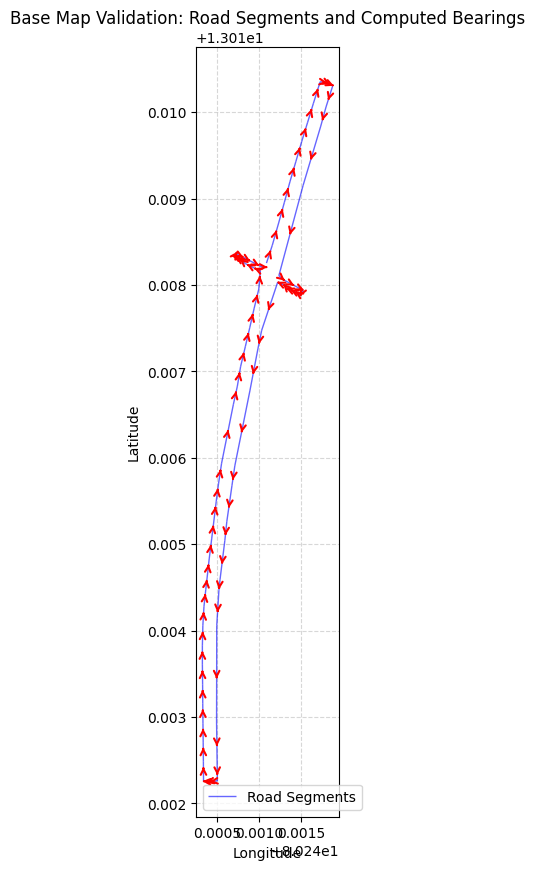

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load the built base map
edges_gdf = gpd.read_file("base_map_edges.shp") # 

# 1. Setup the plot
fig, ax = plt.subplots(figsize=(12, 10))
edges_gdf.plot(ax=ax, color='blue', linewidth=1, alpha=0.6, label='Road Segments') # 

# 2. Add Directional Arrows based on 'bearing'
# We take the midpoint of each segment to place the arrow
for idx, row in edges_gdf.iterrows():
    # Get coordinates of the segment start
    line = row.geometry
    x_start, y_start = line.coords[0]
    x_end, y_end = line.coords[-1]
    
    # Calculate midpoint for the arrow placement
    mid_x = (x_start + x_end) / 2
    mid_y = (y_start + y_end) / 2
    
    # Convert bearing back to cartesian angle for plotting
    # (Bearing 0 is North, Matplotlib angle 0 is East)
    angle = (450 - row['bearing']) % 360 # 
    
    # Add arrow indicating travel direction
    ax.annotate('', xy=(mid_x + np.cos(np.radians(angle))*0.00005, 
                       mid_y + np.sin(np.radians(angle))*0.00005),
                xytext=(mid_x, mid_y),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# 3. Formatting
ax.set_title("Base Map Validation: Road Segments and Computed Bearings")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()